In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
FILE_PATH_1 = 'robotics_experiments/initial_detection_exps/robot1_with_hard_detection_trial_1.csv'
FILE_PATH_2 = 'robotics_experiments/initial_detection_exps/robot2_with_hard_detection_trial_1.csv'

In [3]:
N_COLUMNS = 36 # should infer from df number of columns

ROBOT_INFO_SIZE = 3
DETECTION_INFO_SIZE = 1
CLUSTER_INFO_SIZE = 4

N_CLUSTERS = int((N_COLUMNS - ROBOT_INFO_SIZE - DETECTION_INFO_SIZE) / CLUSTER_INFO_SIZE)

In [4]:
def load_robot_data(file_path):
    df = pd.read_csv(file_path, header=None)
    column_names = ['robot_x', 'robot_y', 'robot_angle']
    for i in range(N_CLUSTERS):
        column_names.extend([f'cluster{i}_x', f'cluster{i}_y', f'cluster{i}_angle', f'cluster{i}_w'])
    column_names.append('has_detection')
    df.columns = column_names
    return df
    
df_robot1 = load_robot_data(FILE_PATH_1)
df_robot2 = load_robot_data(FILE_PATH_2)

In [5]:
def compute_estimated_position_x(row):
    estimated_x = 0
    sum_weights = 0
    for i in range(N_CLUSTERS):
        estimated_x += row[f'cluster{i}_x'] * row[f'cluster{i}_w']
        sum_weights += row[f'cluster{i}_w']
        
    return estimated_x / sum_weights

def compute_estimated_position_y(row):
    estimated_y = 0
    sum_weights = 0
    for i in range(N_CLUSTERS):
        estimated_y += row[f'cluster{i}_y'] * row[f'cluster{i}_w']
        sum_weights += row[f'cluster{i}_w']
        
    return estimated_y / sum_weights
    
def compute_estimation_eror(row):
    diff_x_square = (row['robot_x'] - row['estimated_x']) ** 2
    diff_y_square = (row['robot_y'] - row['estimated_y']) ** 2
    return np.sqrt(diff_x_square + diff_y_square)

def compute_robot_estimation_error(df):
    df['estimated_x'] = df.apply(compute_estimated_position_x, axis=1)
    df['estimated_y'] = df.apply(compute_estimated_position_y, axis=1)
    df['error'] = df.apply(compute_estimation_eror, axis=1)
    return df

df_robot1 = compute_robot_estimation_error(df_robot1)
df_robot2 = compute_robot_estimation_error(df_robot2)

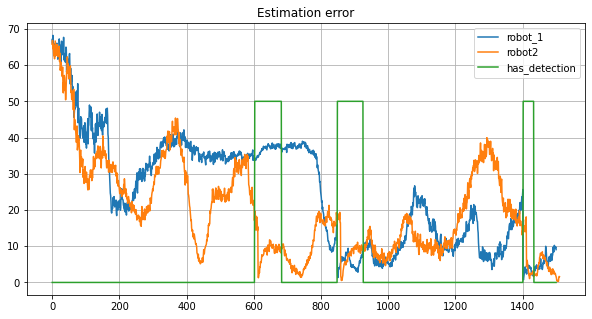

In [6]:
plt.figure(figsize=(10, 5))
plt.title('Estimation error')
plt.plot(df_robot1.error)
plt.plot(df_robot2.error)
plt.plot(df_robot1.has_detection * 50)
plt.legend(['robot_1', 'robot2', 'has_detection'])
plt.grid()
plt.show()

Done!